# Partial Dependence Plots

In [96]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

## For Regression task

Load the Boston Housing dataset.

In [74]:
(train_features, train_labels), (test_features, test_labels) = tf.keras.datasets.boston_housing.load_data()
features = [('CRIM', 'crime_rate'), ('ZN', 'residential_zone'),
            ('INDUS', 'prop_non-retail'), ('CHAS', 'river_adjacent'),
            ('NOX', 'NO_concentration'), ('RM', 'avg_rooms'),
            ('AGE', 'age'), ('DIS', 'employment_proximit'),
            ('RAD', 'radial_highways'), ('TAX', 'tax_rate'),
            ('PTRATIO', 'pupil-teacher_ratio'), ('B', 'prop_black'),
            ('LSTAT', 'lower_status_pop')]
df_train_features = pd.DataFrame(train_features, columns=[feature[0] for feature in features])
df_train_labels = pd.DataFrame({'MEDV': train_labels})
df = pd.concat((df_train_features, df_train_labels), axis=1)

In [75]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72,15.2
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11,42.3
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,50.0
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01,21.1
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65,17.7


In [76]:
df.CHAS = df.CHAS.apply(lambda x: 'T' if x==1.0 else 'F')

In [77]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,1.23247,0.0,8.14,F,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72,15.2
1,0.02177,82.5,2.03,F,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11,42.3
2,4.89822,0.0,18.10,F,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,50.0
3,0.03961,0.0,5.19,F,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01,21.1
4,3.69311,0.0,18.10,F,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65,17.7


In [78]:
# Numerical Variables
num_vars = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
           'TAX', 'PTRATIO', 'B', 'LSTAT']

# Categorical variables
cat_vars = ['CHAS']

X = df[num_vars + cat_vars]

# Label
y = df['MEDV']

In [79]:
# Create models
mlp_reg = MLPRegressor(hidden_layer_sizes=[300, 200, 100],
                       max_iter=700)

# Create pipeline
transformer = ColumnTransformer([
    ('numerical', MinMaxScaler(feature_range=(-1,1)), num_vars),
    ('categorical', OneHotEncoder(), cat_vars),
])

reg_pipeline = Pipeline(steps=[
    ('transform', transformer),
    ('model', mlp_reg)
])

# Create dataset
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, random_state=1337)

reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numerical',
                                                  MinMaxScaler(feature_range=(-1,
                                                                              1)),
                                                  ['CRIM', 'ZN', 'INDUS', 'NOX',
                                                   'RM', 'AGE', 'DIS', 'RAD',
                                                   'TAX', 'PTRATIO', 'B',
                                                   'LSTAT']),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  ['CHAS'])])),
                ('model',
                 MLPRegressor(hidden_layer_sizes=[300, 200, 100],
                              max_iter=700))])

Compute the mean square error of the MLP model.

In [80]:
model_mse_error = np.sqrt(np.mean((reg_pipeline.predict(X_test) - y_test)**2))
print(f'Mean squared error of MLP model: {model_mse_error}')

Mean squared error of MLP model: 2.8912322040142295


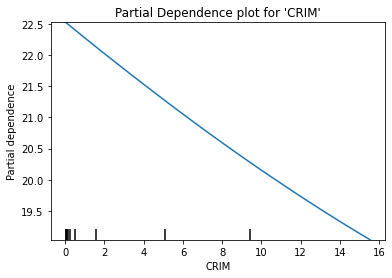

In [81]:
PartialDependenceDisplay.from_estimator(
    reg_pipeline, X_train, features=['CRIM']
)
plt.title("Partial Dependence plot for 'CRIM'")
plt.show()

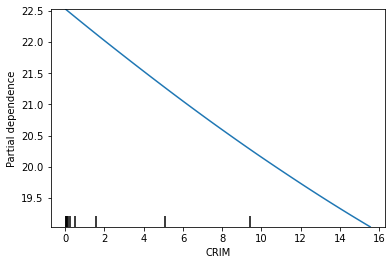

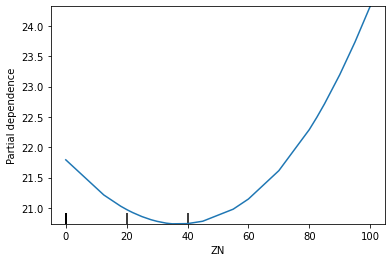

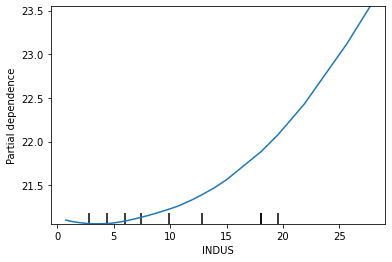

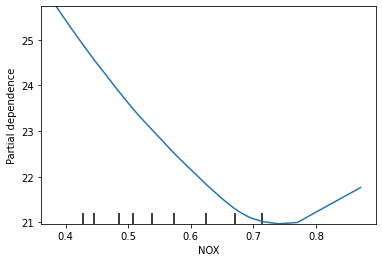

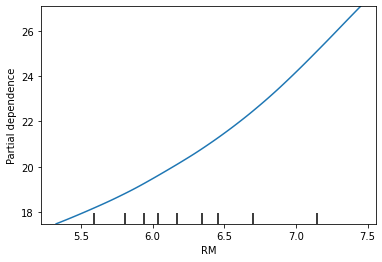

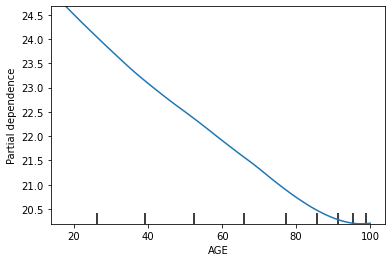

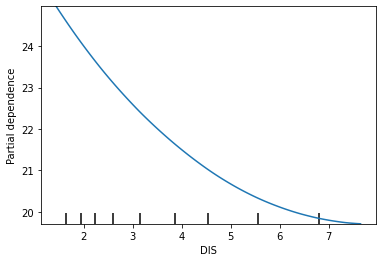

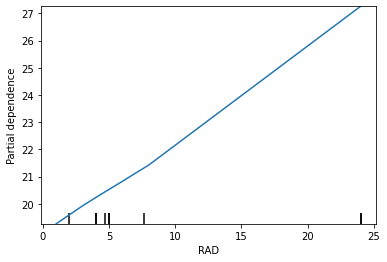

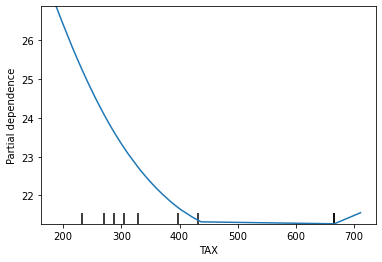

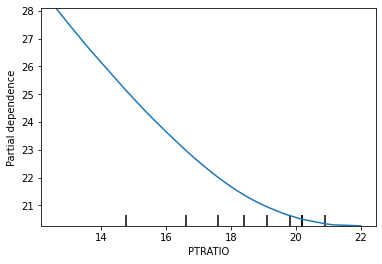

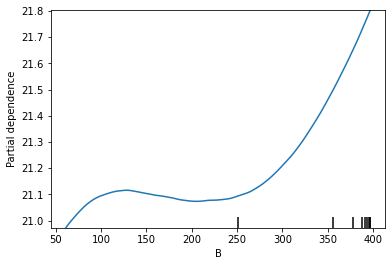

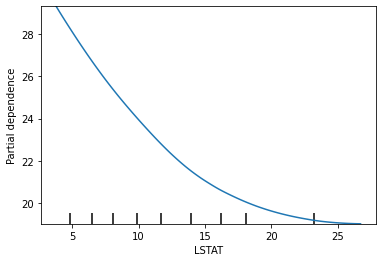

In [82]:
for feature in num_vars:
    PartialDependenceDisplay.from_estimator(
        reg_pipeline, X_train, features=[feature])

### Compute partial dependence for categorical feature

In [83]:
# first for 'CHAS'
X_pdp = X_train.copy()

X_pdp['CHAS'] = ['F']*X_pdp.shape[0]
CHAS_F_pd = reg_pipeline.predict(X_pdp).mean()
print(f"Partial Dependence Estimate for CHAS=='F': {CHAS_F_pd}")
X_pdp['CHAS'] = ['T']*X_pdp.shape[0]
CHAS_T_pd = reg_pipeline.predict(X_pdp).mean()
print(f"Partial Dependence Estimate for CHAS=='T': {CHAS_T_pd}")

Partial Dependence Estimate for CHAS=='F': 21.575801276627914
Partial Dependence Estimate for CHAS=='T': 23.868755818646246


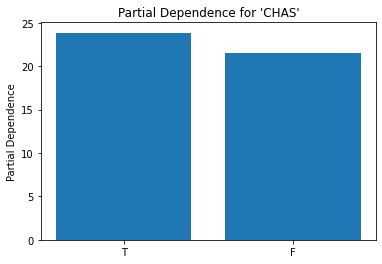

In [84]:
plt.bar(('T','F'), (CHAS_T_pd,CHAS_F_pd))
plt.title("Partial Dependence for 'CHAS'")
plt.ylabel('Partial Dependence')
plt.show()

In [85]:
from scipy.stats import pearsonr
pearsonr(df['INDUS'], df['NOX'])[0]

0.7741996063949141

In [86]:
from scipy.stats import pearsonr

corr_coeff = pearsonr(df['INDUS'], df['NOX'])[0]
print(f'Pearson correlation coeff: {corr_coeff}')

Pearson correlation coeff: 0.7741996063949141


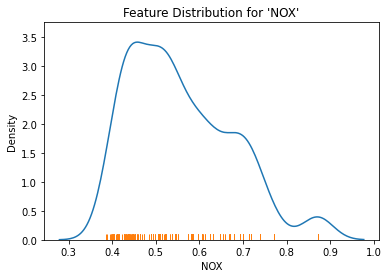

In [87]:
sns.kdeplot(x=df['NOX'])
sns.rugplot(x=df['NOX'])
plt.title("Feature Distribution for 'NOX'")
plt.show()

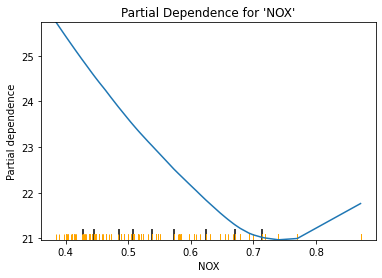

In [88]:
PartialDependenceDisplay.from_estimator(
    reg_pipeline, X_train, features=['NOX'])
sns.rugplot(data=X_train, x='NOX', color='orange')
plt.title("Partial Dependence for 'NOX'")
plt.show()

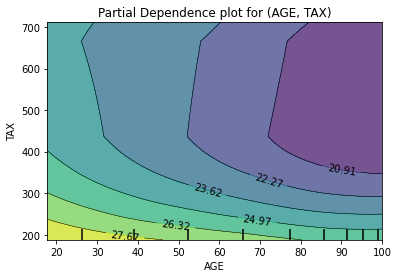

In [89]:
PartialDependenceDisplay.from_estimator(
    reg_pipeline, X_train, features=[('AGE', 'TAX')])
plt.title('Partial Dependence plot for (AGE, TAX)')
plt.show()

## For Classification Task

Load the dataset.

In [97]:
df = pd.read_csv('heart.csv')

In [98]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [99]:
df.FastingBS = df.FastingBS.apply(lambda x: 'T' if x==1 else 'F')

In [100]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,F,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,F,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,F,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,F,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,F,Normal,122,N,0.0,Up,0


In [101]:
# Categorical variables
cat_vars = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Numerical Variables
num_vars = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

X = df[num_vars + cat_vars]

# Label
y = df['HeartDisease']

In [102]:
X.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,ST_Slope
0,40,140,289,172,0.0,M,ATA,F,Normal,N,Up
1,49,160,180,156,1.0,F,NAP,F,Normal,N,Flat
2,37,130,283,98,0.0,M,ATA,F,ST,N,Up
3,48,138,214,108,1.5,F,ASY,F,Normal,Y,Flat
4,54,150,195,122,0.0,M,NAP,F,Normal,N,Up


In [103]:
# Create models
gb_clf = GradientBoostingClassifier(
    n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0
)

# Create pipeline
transformer = ColumnTransformer([
    ('numerical', StandardScaler(), num_vars),
    ('categorical', OneHotEncoder(), cat_vars),
])

clf_pipeline = Pipeline(steps=[
    ('transform', transformer),
    ('classifier', gb_clf)
])

# Create dataset
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, random_state=1337)

clf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  ['Sex', 'ChestPainType',
                                                   'FastingBS', 'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=1,
                                            random_state=0))])

In [104]:
clf_pipeline.score(X_test, y_test)

0.9021739130434783

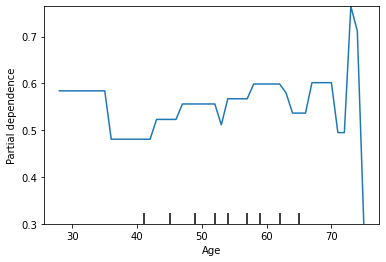

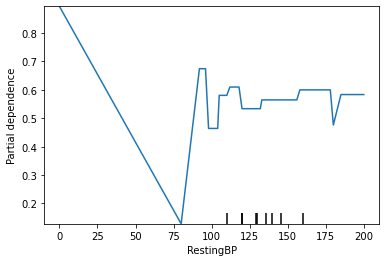

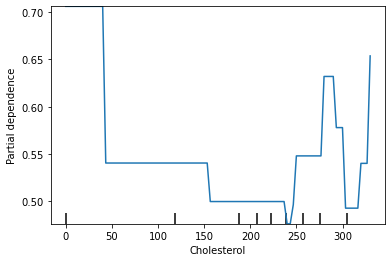

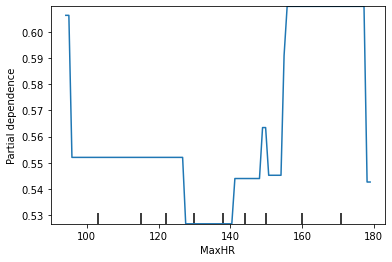

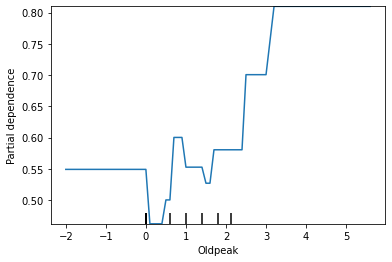

In [107]:
for feature in num_vars:
    PartialDependenceDisplay.from_estimator(clf_pipeline, X_train, features=[feature])

Plot with rug plot below.

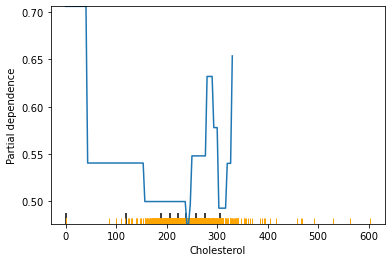

In [108]:
age_pdp = PartialDependenceDisplay.from_estimator(clf_pipeline, X_train, features=['Cholesterol'])
age_rug = sns.rugplot(data=X_train, x='Cholesterol', color='orange')
plt.show()

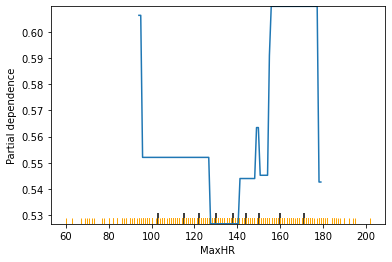

In [109]:
age_pdp = PartialDependenceDisplay.from_estimator(clf_pipeline, X_train, features=['MaxHR'])
age_rug = sns.rugplot(data=X_train, x='MaxHR', color='orange')
plt.show()

## Dealing with Categorical Features

### For 'Sex' feature

In [110]:
# first for 'M'
X_pdp = X.copy()
X_pdp['Sex'] = ['M']*X_pdp.shape[0]
print(clf_pipeline.predict(X_pdp).mean())

0.5871459694989106


In [111]:
cat_pdp_dict = {}
for cat_var in cat_vars:
    feature_pdp_dict = {}
    feature_vals = X_train[cat_var].unique()
    for feature_val in feature_vals:
        X_pdp = X_train.copy()
        X_pdp[cat_var] = [feature_val]*X_pdp.shape[0]
        feature_pdp_dict[feature_val] = clf_pipeline.predict(X_pdp).mean()
    cat_pdp_dict[cat_var] = feature_pdp_dict

In [112]:
cat_pdp_dict

{'Sex': {'M': 0.6008174386920981, 'F': 0.48365122615803813},
 'ChestPainType': {'ASY': 0.659400544959128,
  'ATA': 0.4373297002724796,
  'NAP': 0.4768392370572207,
  'TA': 0.4768392370572207},
 'FastingBS': {'F': 0.5613079019073569, 'T': 0.6171662125340599},
 'RestingECG': {'LVH': 0.5722070844686649,
  'ST': 0.5722070844686649,
  'Normal': 0.5722070844686649},
 'ExerciseAngina': {'Y': 0.6062670299727521, 'N': 0.5354223433242506},
 'ST_Slope': {'Flat': 0.7343324250681199,
  'Down': 0.5572207084468664,
  'Up': 0.34332425068119893}}

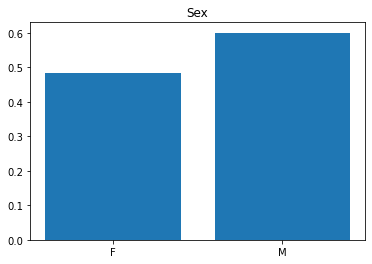

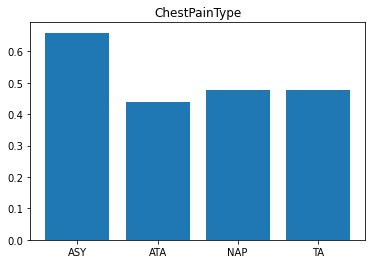

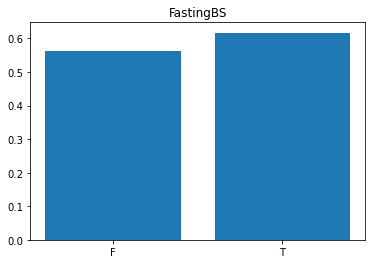

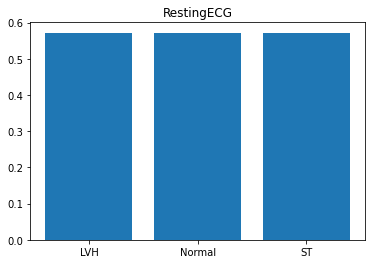

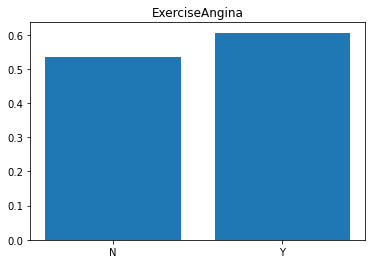

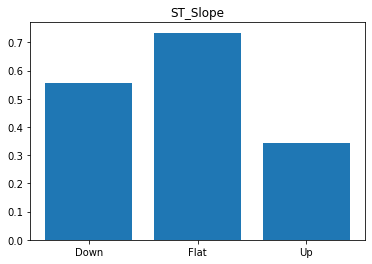

In [113]:
for cat_var in cat_vars:
    plt.bar(*zip(*sorted(cat_pdp_dict[cat_var].items())))
    plt.title(cat_var)
    plt.show()

## Dealing with Multi-Class classification

In [114]:
# To download the dataset.
#!wget http://www3.dsi.uminho.pt/pcortez/wine/winequality.zip
#!unzip winequality.zip

In [115]:
df = pd.read_csv("./winequality/winequality-red.csv", sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [116]:
df.quality.unique()

array([5, 6, 7, 4, 8, 3])

In [117]:
num_feats = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']

X = df[num_feats]
y = df['quality']

In [123]:
multi_clf = OneVsRestClassifier(
    MLPClassifier(
        hidden_layer_sizes=[256, 128, 64, 32],
        max_iter=750)
    ).fit(X, y)

# Create pipeline
transformer = ColumnTransformer([
    ('numerical', StandardScaler(), num_feats),
])


multi_clf_pipeline = Pipeline(steps=[
    ('transform', transformer),
    ('classifier', multi_clf
    )
])


In [124]:
multi_clf_pipeline.fit(X,y)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['fixed acidity',
                                                   'volatile acidity',
                                                   'citric acid',
                                                   'residual sugar',
                                                   'chlorides',
                                                   'free sulfur dioxide',
                                                   'total sulfur dioxide',
                                                   'density', 'pH', 'sulphates',
                                                   'alcohol'])])),
                ('classifier',
                 OneVsRestClassifier(estimator=MLPClassifier(hidden_layer_sizes=[256,
                                                                                 128,
                                                   

In [125]:
multi_clf_pipeline.score(X, y)

0.9943714821763602

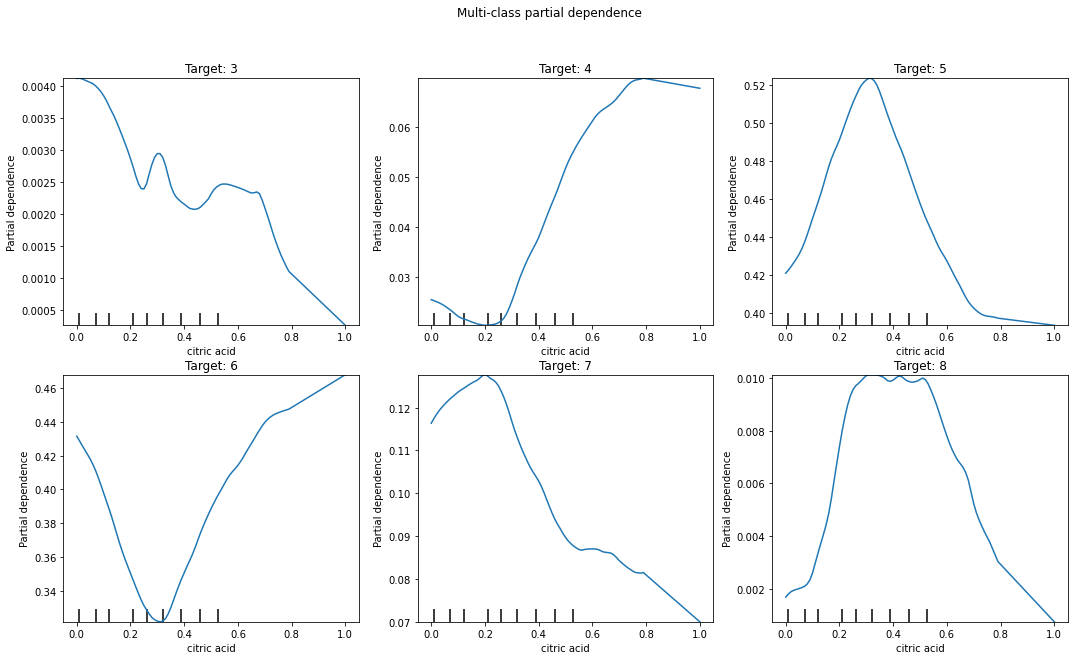

In [126]:
fig, ((ax3, ax4, ax5), (ax6, ax7, ax8)) = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Multi-class partial dependence')

target3_disp = PartialDependenceDisplay.from_estimator(
    multi_clf_pipeline, X, features=['citric acid'], target=3, ax=ax3)
target4_disp = PartialDependenceDisplay.from_estimator(
    multi_clf_pipeline, X, features=['citric acid'], target=4, ax=ax4)
target5_disp = PartialDependenceDisplay.from_estimator(
    multi_clf_pipeline, X, features=['citric acid'], target=5, ax=ax5)
target6_disp = PartialDependenceDisplay.from_estimator(
    multi_clf_pipeline, X, features=['citric acid'], target=6, ax=ax6)
target7_disp = PartialDependenceDisplay.from_estimator(
    multi_clf_pipeline, X, features=['citric acid'], target=7, ax=ax7)
target8_disp = PartialDependenceDisplay.from_estimator(
    multi_clf_pipeline, X, features=['citric acid'], target=8, ax=ax8)

ax3.set_title("Target: 3")
ax4.set_title("Target: 4")
ax5.set_title("Target: 5")
ax6.set_title("Target: 6")
ax7.set_title("Target: 7")
ax8.set_title("Target: 8")
plt.show()

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License

## Tensorflow model (not used)

In [56]:
# def create_dataset(pattern, label_col, batch_size=1, mode='eval'):
#     dataset = tf.data.experimental.make_csv_dataset(
#         pattern, batch_size=batch_size, label_name=label_col,
#         shuffle=True, shuffle_buffer_size=10*batch_size)
#     return dataset

In [57]:
# dataset = create_dataset('./heart.csv', label_col='HeartDisease', batch_size=5)

# for feature_batch, label_batch in dataset.take(1):
#   print("'HeartDisease': {}".format(label_batch))
#   print("features:")
#   for key, value in feature_batch.items():
#     print("  {!r:20s}: {}".format(key, value))

In [58]:
# def df_to_dataset(dataframe, label_col, shuffle=True, batch_size=32):
#     dataframe = dataframe.copy()
#     labels = dataframe.pop(label_col)
#     ds = tf.data.Dataset.from_tensor_slices((dict(dataframe)))
#     if shuffle:
#         ds = ds.shuffle(buffer_size=len(dataframe))
#     ds = ds.batch(batch_size)
#     return ds

In [59]:
# train, valid = train_test_split(df, test_size=0.2)

# train_ds = df_to_dataset(train, 'HeartDisease')
# val_ds = df_to_dataset(valid, 'HeartDisease', shuffle=False)

In [60]:
# for feature_batch in val_ds.take(1):
#   print("'HeartDisease': {}".format(label_batch))
#   print("features:")
#   for key, value in feature_batch.items():
#     print("  {!r:20s}: {}".format(key, value))

In [61]:
# NUMERIC_COLS = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR','Oldpeak']

# feature_columns = {
#     col: tf.feature_column.numeric_column(key=col) for col in NUMERIC_COLS
# }

# cat_columns = {
#     'Sex': tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_vocabulary_list(
#             key='Sex', vocabulary_list=['M', 'F'])),
#     'ChestPainType': tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_vocabulary_list(
#             key='ChestPainType', vocabulary_list=['ATA', 'NAP', 'ASY', 'TA'])),
#     'RestingECG': tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_vocabulary_list(
#             key='RestingECG', vocabulary_list=['ATA', 'NAP', 'ASY', 'TA'])),
#     'ST_Slope': tf.feature_column.indicator_column(
#         tf.feature_column.categorical_column_with_vocabulary_list(
#             key='ST_Slope', vocabulary_list=['Up', 'Flat', 'Down'])),
# }

# feature_columns.update(cat_columns)

In [62]:
# def build_dnn():
#     model = tf.keras.models.Sequential(
#         [
#             # tf.keras.layers.DenseFeatures(feature_columns=feature_columns.values()),
#             tf.keras.layers.InputLayer(input_shape=(6)),
#             tf.keras.layers.Dense(units=64, activation="relu", name="h1"),
#             tf.keras.layers.Dense(units=32, activation="relu", name="h2"),
#             tf.keras.layers.Dense(units=8, activation="relu", name="h3"),
#             tf.keras.layers.Dense(units=1, activation="linear", name="output"),
#         ]
#     )
#     # Compile the keras model
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#                   metrics=["accuracy"])
#     return model

In [63]:
# history = model.fit(train_ds,
#                     validation_data=val_ds,
#                     epochs=20,
#                     verbose=0)

In [64]:
# pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
# pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

In [65]:
# from keras.wrappers.scikit_learn import KerasClassifier

In [66]:
# NUMERIC_COLS = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR','Oldpeak']
# df[NUMERIC_COLS].shape

In [67]:
# kr = KerasClassifier(build_fn=build_dnn, verbose=0)
# kr.fit(x=df[NUMERIC_COLS],
#        y=df['HeartDisease'],
#        epochs=20,
#        verbose=0)

In [68]:
# pd.DataFrame(history.history)[['loss']].plot()
# pd.DataFrame(history.history)[['accuracy']].plot()